In [355]:
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
from keras_vggface import utils
from keras_vggface.vggface import VGGFace
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Layer, Lambda
from keras import regularizers
from keras.losses import categorical_crossentropy
import keras.utils
from keras import backend as K

## Step 1: Prepare the training data
Define the path to the face data directory

In [356]:
data_dir = 'face_data'

Load the face images and labels

In [357]:
X_train = []
y_train = []
for person_name in os.listdir(data_dir):
    person_dir = os.path.join(data_dir, person_name)
    for image_name in os.listdir(person_dir):
        image_path = os.path.join(person_dir, image_name)
        image = tf.keras.utils.load_img(image_path, target_size=(224, 224))
        X_train.append(tf.keras.utils.img_to_array(image))
        y_train.append(person_name)

Show image

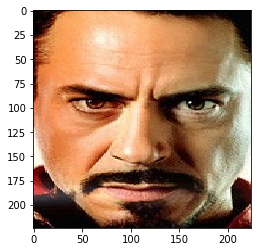

In [358]:
plt.imshow(X_train[3].astype('uint8'), interpolation='nearest')
plt.show()

number of label

In [359]:
num_classes = len(os.listdir(data_dir))

Convert the face images and labels to numpy arrays

In [360]:
X_train = np.array(X_train)
y_train = np.array(y_train)

Label-encode the person names

In [361]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)

## Step 2: ArcFace

ArcFace Layer

In [362]:
class ArcFaceLayer(Layer):
    def __init__(self, num_classes, m=0.5, s=64.0, regularizer=None, **kwargs):
        super(ArcFaceLayer, self).__init__(**kwargs)
        self.num_classes = num_classes
        self.regularizer = regularizer
        self.m = m
        self.s = s

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], self.num_classes),
                                 initializer='glorot_uniform',
                                 trainable=True, 
                                 regularizer=self.regularizer,
                                 name='W')
        
    def call(self, inputs):
        # normalize input features
        x = tf.nn.l2_normalize(inputs, axis=1)
        # normalize weights
        W = tf.nn.l2_normalize(self.W, axis=0)
        # dot product between features and weights
        logits = tf.matmul(x, W)
        return logits

ArcFace loss function

In [363]:
def arcface_loss(y_true, y_pred, m=0.5, s=64.0):
    # normalize input features
    embeddings = tf.nn.l2_normalize(y_pred, axis=1)

    # normalize weights
    W = tf.nn.l2_normalize(tf.ones((embeddings.shape[1], y_true.shape[1])), axis=0)

    # compute logits
    logits = tf.matmul(embeddings, W)

    # add margin
    theta = tf.acos(tf.clip_by_value(logits, -1.0 + tf.keras.backend.epsilon(), 1.0 - tf.keras.backend.epsilon()))
    target_logits = tf.cos(theta + m)

    # multiply with scaling parameter
    logits *= s

    # apply cross-entropy loss
    logits_softmax = tf.nn.softmax(logits, axis=-1)
    ce_loss = tf.losses.categorical_crossentropy(y_true, logits_softmax)

    # add the ArcFace margin loss
    target_logits_softmax = tf.nn.softmax(target_logits, axis=-1)
    arcface_loss = tf.losses.categorical_crossentropy(y_true, target_logits_softmax)

    return ce_loss + arcface_loss


## Step 4: Define model

Define the VGG-Face model as the feature extraction backbone

In [364]:
backbone = VGGFace(model='vgg16', include_top=False,
                   input_shape=(224, 224, 3), pooling='avg')

Define the full face recognition model

In [365]:
model = Sequential([
    backbone,
    Dropout(0.5),
    Dense(num_classes, activation='softmax'),
    Dropout(0.5),
    ArcFaceLayer(num_classes=num_classes,
            regularizer=regularizers.l2(0.01))
])

## Step 4: compile model

compile model

In [366]:
model.compile(loss=arcface_loss,
              optimizer='adam', metrics=['accuracy'])

## Step 5: Train the model

Load model

In [367]:
# try:
#   model = keras.models.load_model(os.getcwd())
# except:
#   print('error')
#   pass

Convert the training labels to one-hot encoded vectors

In [368]:
y_train_onehot = keras.utils.np_utils.to_categorical(
    y_train, num_classes=num_classes)

save model

In [369]:
# model.save(os.getcwd())

Train the face recognition model

In [370]:
model.fit(X_train, y_train_onehot, batch_size=32,
          epochs=5, validation_split=0.1)

Epoch 1/5
1/1 [==============================] - 10s 10s/step - loss: 2.2466 - accuracy: 0.3750 - val_loss: 2.2465 - val_accuracy: 1.0000
Epoch 2/5
1/1 [==============================] - 5s 5s/step - loss: 2.2465 - accuracy: 0.3750 - val_loss: 2.2463 - val_accuracy: 1.0000
Epoch 3/5
1/1 [==============================] - 6s 6s/step - loss: 2.2463 - accuracy: 0.5000 - val_loss: 2.2462 - val_accuracy: 1.0000
Epoch 4/5
1/1 [==============================] - 5s 5s/step - loss: 2.2462 - accuracy: 0.3750 - val_loss: 2.2461 - val_accuracy: 1.0000
Epoch 5/5
1/1 [==============================] - 5s 5s/step - loss: 2.2461 - accuracy: 0.2500 - val_loss: 2.2460 - val_accuracy: 1.0000


## Step 6: Predict

In [371]:
# Load image
image_path = 'D:/PPNCKH/test/4585_teddy.png'
image = tf.keras.utils.load_img(image_path, target_size=(224, 224))
x = tf.keras.utils.img_to_array(image)
x = np.expand_dims(x, axis=0)
x = utils.preprocess_input(x)

# Use the trained model to make a prediction
prediction = model.predict(x)

print(prediction)

1/1 [==============================] - 0s 287ms/step
[[ 0.6570829  -0.86918616  0.6791104 ]]
